In [14]:
from mugnier.basis.dvr import SineDVR
from mugnier.heom.bath import (BoseEinstein, Correlation, DiscreteVibration, Drude, UnderdampedBrownian)
from mugnier.heom.hierachy import (ExtendedDensityTensor, Hierachy, SineExtendedDensityTensor, SineHierachy)
from mugnier.libs import backend
from mugnier.libs.logging import Logger
from mugnier.libs.quantity import Quantity as __
from mugnier.operator.spo import Integrator
from tqdm import trange

- Define the models

In [15]:
betas = {'HT': __(1 / 100_000, '/K').au, 'ZT': None, 'RT': __(1 / 300, '/K').au}

# System settings:
e = __(5000.0, '/cm').au
v = __(0.0, '/cm').au
h = backend.array([[0, v], [v, e]])
op = backend.array([[0.0, 0.0], [0.0, 1.0]])
rdo = backend.array([[0.5, 0.5], [0.5, 0.5]])

# Bath settings:
include_drude = True
include_brownian = False
include_discrete = False

distr = BoseEinstein(n=3, beta=betas['RT'])
corr = Correlation(distr)
if include_drude:
    corr += Drude(__(200, '/cm').au, __(50, '/cm').au, distr)
if include_brownian:
    corr += UnderdampedBrownian(__(500, '/cm').au, __(1500, '/cm').au, __(50, '/cm').au, distr)
if include_discrete:
    corr += DiscreteVibration( __(1500, '/cm').au, __(500, '/cm').au, distr)

# HEOM basis settings
use_dvr = True
scaling_factor = None
dim = 20
dvr_length = 100

# Propagator settings:
callback_steps = 10
steps = 500 * callback_steps
interval = __(0.1 / callback_steps, 'fs')
ode_method = 'dopri5'

# logging
if include_drude and include_brownian:
    prefix = 'all'
elif include_brownian:
    prefix = 'brownian'
elif include_drude:
    prefix = 'drude'
else:
    prefix = 'dummy'
fname = prefix + f'-{"dvr" if use_dvr else "heom"}-{corr.k_max}({dim})'
if use_dvr:
    fname += f'-L{dvr_length}'

In [16]:
def iter_hierachy():
    corr.print()
    logger = Logger(filename=fname + '.log', level='info').logger
    logger.info(f'# device:{backend.device} | use_DVR:{use_dvr} | Brownian:{include_brownian} | Drude:{include_drude}')
    logger.info(f'# dim:{dim} | K:{corr.k_max} | ODE_method:{ode_method} | dt:{interval} | callback:{callback_steps}')

    if not use_dvr:
        dims = [dim] * corr.k_max
        Hierachy.scaling_factor = scaling_factor
        heom_op = Hierachy(h, op, corr, dims)
        s = ExtendedDensityTensor(rdo, dims)
    else:
        bases = [(-dvr_length, dvr_length, dim)] * corr.k_max
        SineHierachy.scaling_factor = scaling_factor
        heom_op = SineHierachy(h, op, corr, bases)
        s = SineExtendedDensityTensor(rdo, bases)
    solver = Integrator(heom_op, s)

    logger.info('# time rdo00 rdo01 rdo10 rdo11')
    it = trange(steps)
    for i in it:
        solver.odeint(interval.au, method=ode_method)
        if i % callback_steps == 0:
            _t = interval * i
            _rdo = s.get_rdo()
            logger.info(f'{_t.au} {_rdo[0, 0]} {_rdo[0, 1]} {_rdo[1, 0]} {_rdo[1, 1]}')

            yield s[s.root]

            trace = abs(_rdo[0, 0] + _rdo[1, 1])
            coh = abs(_rdo[0, 1])
            it.set_description(f'Time:{_t.value:.2f}fs | Tr:{trace:.4f} | Coh:{coh:.4f}')

In [17]:
for _ in iter_hierachy():
    pass

Correlation coefficents:
            c: [1.7231816e-06-2.0760191e-07j 1.3238414e-07+0.0000000e+00j
 8.3395243e-08+0.0000000e+00j 2.5748091e-07+0.0000000e+00j];
            (c* = [1.7231816e-06+2.0760191e-07j 1.3238414e-07-0.0000000e+00j
 8.3395243e-08-0.0000000e+00j 2.5748091e-07-0.0000000e+00j];)
            gamma: [-0.00022782+0.j -0.0059694 +0.j -0.01231094+0.j -0.03431489+0.j].
        


Time:0.10fs | Tr:0.0404 | Coh:0.0202:   0%|          | 20/5000 [00:35<2:28:16,  1.79s/it]

rm: cannot remove 'data/*.png': No such file or directory
Correlation coefficents:
            c: [1.7231816e-06-2.0760191e-07j 1.3238414e-07+0.0000000e+00j
 8.3395243e-08+0.0000000e+00j 2.5748091e-07+0.0000000e+00j];
            (c* = [1.7231816e-06+2.0760191e-07j 1.3238414e-07-0.0000000e+00j
 8.3395243e-08-0.0000000e+00j 2.5748091e-07-0.0000000e+00j];)
            gamma: [-0.00022782+0.j -0.0059694 +0.j -0.01231094+0.j -0.03431489+0.j].
        


  0%|          | 0/5000 [00:01<?, ?it/s]


TypeError: Input z must be 2D, not 4D

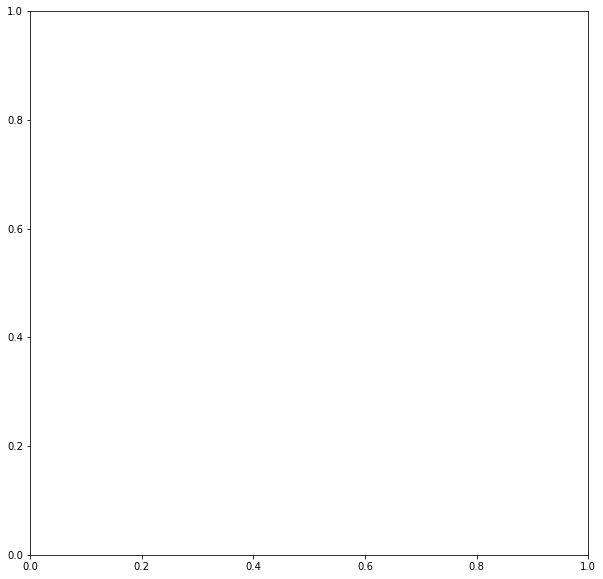

In [ ]:
# !rm data/*.png

# from matplotlib import pyplot as plt
# from matplotlib import cm
# import numpy as np
# plt.rcParams["figure.figsize"] = (10,10)

# if not use_dvr:
#     basis = SineDVR(-32, 32, 512)
#     x = basis.grid_points
#     xx, yy = np.meshgrid(x, x)
#     tfmat = backend.optimize(basis.fock2dvr_mat[:, :dim])
# else:
#     basis = SineDVR(-dvr_length, dvr_length, dim)
#     x = basis.grid_points
#     xx, yy = np.meshgrid(x, x)
#     tfmat = backend.optimize(basis.fock2dvr_mat)

# levels = np.linspace(-32, 32, 100)
# for i, edt in enumerate(iter_hierachy()):
#     if not use_dvr:
#         for _i in range(2):
#             edt = backend.opt_tensordot(edt, tfmat, ([_i + 2], [1])).moveaxis(-1, _i + 2)
    
#     edt_np = edt.cpu().numpy()
#     _d = edt_np.shape[-1]
#     pop = np.abs(edt_np[0, 0, :, :]) * _d
#     coh = np.abs(edt_np[0, 1, :, :]) * _d
#     plt.contourf(xx, yy, coh, levels, cmap=cm.seismic)
#     plt.xlim(-10, 10)
#     plt.ylim(-10, 10)
#     plt.savefig(f'data/{i:05d}.png')
#     plt.close()

# !ffmpeg -framerate 50 -pattern_type glob -i 'data/*.png' -c:v libx264 -pix_fmt yuv420p data/out.mp4 -y
# !rm data/*.png

In [ ]:
# %matplotlib inline
# from matplotlib import pyplot as plt
# from matplotlib import cm
# import numpy as np
# import matplotlib.animation as animation
# plt.rcParams["figure.figsize"] = (10,10)

# basis = SineDVR(-100, 100, 100)
# x = basis.grid_points
# tfmat = backend.optimize(basis.fock2dvr_mat[:, :dim])

# for i, edt in enumerate(iter_hierachy()):
#     if not use_dvr:
#         edt = backend.opt_tensordot(edt, tfmat, ([2], [1])).moveaxis(-1, 2)
#     else:
#         raise NotImplementedError
#     edt_np = edt.cpu().numpy()
#     pop = np.abs(edt_np[0, 0, :, 0])
#     coh = np.abs(edt_np[0, 1, :, 0])
#     plt.plot(x, coh)
#     plt.xlim(-5, 5)
#     plt.ylim(-5, 5)
#     plt.savefig(f'{i:05d}')
#     plt.close()